# H&M Fashion Recommender Notebook

For each customer (customer_id), H&M want a prediction of up to 12 products (article_ids), which is the predicted items a customer will buy in the next 7-day period after the training time period. The file should contain a header and have the following format.

In [122]:
#working with files and memory management
import gc

import pandas as pd
import numpy as np

#used during data exploration
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

#handling missing values where not dropped
from sklearn.impute import SimpleImputer
from sklearn import preprocessing

#ML model
from sklearn.neighbors import NearestNeighbors

# Cross-Validation (on a rolling basis)
from sklearn.model_selection import TimeSeriesSplit

# performance scoring
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

from IPython.display import display, clear_output

# Get the Data

In [2]:
#get transaction data
transactions_train_df = pd.read_csv("input/transactions_train.csv") # import the transactions dataset

In [3]:
#get product meta data
articles_df = pd.read_csv("input/articles.csv")

In [4]:
#get customer meta data
customers_df = pd.read_csv("input/customers.csv")

# Prepare the Transaction Dataset

In [5]:
#first we will drop the sales channel as it will not be needed
transactions_train_df = transactions_train_df.drop(['sales_channel_id'], axis=1)

In [6]:
#we then convert our date text into a panda date type.
transactions_train_df["t_dat"] = pd.to_datetime(transactions_train_df["t_dat"])

In [7]:
#now we split out the date into seperate columns for day, month and year making use of python zip for memory efficiency
days, months, years  = zip(*[(d.day, d.month, d.year) for d in transactions_train_df['t_dat']])
transactions_train_df = transactions_train_df.assign(day=days, month=months, year=years)

In [8]:
#we drop the t_dat column as it is no longer needed
transactions_train_df = transactions_train_df.drop(['t_dat'], axis=1)

In [9]:
#we convert articles to string instead of default int.
transactions_train_df['article_id'] = transactions_train_df['article_id'].values.astype(str)

In [10]:
#we now reorganise the dataset to treat articles as the predictor
transactions_train_df = transactions_train_df[['article_id', 'year', 'month', 'day', 'price', 'customer_id']]

In [11]:
#we set articles column to index
transactions_train_df.set_index('article_id')

,year,month,day,price,customer_id
article_id,,,,,
663713001,2018,9,20,0.050831,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...
541518023,2018,9,20,0.030492,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...
505221004,2018,9,20,0.015237,00007d2de826758b65a93dd24ce629ed66842531df6699...
685687003,2018,9,20,0.016932,00007d2de826758b65a93dd24ce629ed66842531df6699...
685687004,2018,9,20,0.016932,00007d2de826758b65a93dd24ce629ed66842531df6699...
...,...,...,...,...,...
929511001,2020,9,22,0.059305,fff2282977442e327b45d8c89afde25617d00124d0f999...
891322004,2020,9,22,0.042356,fff2282977442e327b45d8c89afde25617d00124d0f999...
918325001,2020,9,22,0.043203,fff380805474b287b05cb2a7507b9a013482f7dd0bce0e...


In [12]:
# we want to see distributions and std dev
transactions_train_df.describe()

,year,month,day,price
count,3.178832e+07,3.178832e+07,3.178832e+07,3.178832e+07
mean,2.019207e+03,6.511067e+00,1.624134e+01,2.782927e-02
std,6.644412e-01,3.273328e+00,8.934254e+00,1.918113e-02
min,2.018000e+03,1.000000e+00,1.000000e+00,1.694915e-05
25%,2.019000e+03,4.000000e+00,8.000000e+00,1.581356e-02
50%,2.019000e+03,6.000000e+00,1.700000e+01,2.540678e-02
75%,2.020000e+03,9.000000e+00,2.400000e+01,3.388136e-02
max,2.020000e+03,1.200000e+01,3.100000e+01,5.915254e-01


# Prepare the Product Dataset

In [13]:
#get product meta data
articles_df = pd.read_csv('data/articles.csv',
                          index_col=['article_id'],
                          usecols=['article_id',
                                   'product_type_no', #e.g Scarf
                                   'graphical_appearance_no', # e.g stripe
                                   'colour_group_code', #e.g white
                                   'index_group_no',#e.g ladies wear
                                   'detail_desc'],
                          dtype={'article_id': 'str'}) # drop text, no clothing size available

# Split Training and Testing Dataset
We will create a sample from the transactions dataset to inspect relationships and test predictions. We split our sample data into a future test sample and a past training sample

In [14]:
aug_df = transactions_train_df.query('year == 2020 & month == 8').sample(n = 50)

In [15]:
sep_df = transactions_train_df.query('year == 2020 & month == 9').sample(n = 50)

In [16]:
sample_df = pd.concat([aug_df,sep_df])

In [17]:
#we set articles column to index
sample_df.set_index('article_id')

,year,month,day,price,customer_id
article_id,,,,,
534164029,2020,8,29,0.033881,315ffef765f8db3529d17f10c8220b9f5d753e0932fc38...
799365011,2020,8,6,0.048119,fcb0f1dc2b386290142be40d01a0efdaa95ed55ca7893c...
671607001,2020,8,9,0.011729,bdc71770a8ee4e8973a61163e17876ed84af73ff43e313...
861451002,2020,8,26,0.016932,88ab23706f2124c844a4059e5d4e1f26c3c2b9a1f0cd76...
864224005,2020,8,9,0.050831,3b89c8887cb40bf427a9f4db222068e85f84791f4f9115...
...,...,...,...,...,...
844483001,2020,9,7,0.050831,d2f1cc944bc16695a914a295ac03a6d6cc99180219beb2...
818621004,2020,9,17,0.167797,b12201d9b10dbd17af5678dd4fc5c74089f3f9c251f67d...
914868003,2020,9,5,0.033881,e43c29bfc284871206aa12cabf032e846dde451fc13228...


In [18]:
X = sample_df.values
X = X[:,3:5] # day and price
#print(X)#check before scaling

In [19]:
y = sample_df.customer_id.values # get customer ids from sample

In [20]:
tscv = TimeSeriesSplit()
print(tscv)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)


In [21]:
TimeSeriesSplit(max_train_size=None, n_splits=3)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None)

In [22]:
for train_index, test_index in tscv.split(X):
    #print('TRAIN:', train_index, 'TEST:', test_index) 
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [23]:
y_test[15]

'4061d21530a753bb13242f44154b75b83c653dba9d95a520f6e1d275947d2316'

In [24]:
q = X_test[0]# get first item in test set

In [32]:
q[1]

0.0338813559322033

In [25]:
names = y_train

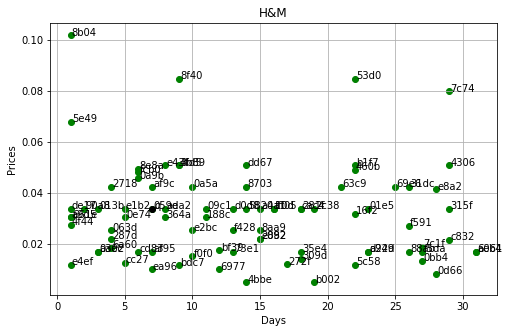

In [33]:
days = X_train[:,0] # x
prices = X_train[:,1] # y

q_days = q[0]
q_price = q[1]

#place day/price points on graph
plt.figure(figsize=(8,5))
plt.scatter(days, prices, color='green')

#place query on graph
plt.scatter(q_days, q_price,color='black')
plt.annotate('q',(q_days+0.2, q_price))

#label graph
plt.title("H&M")
plt.xlabel("Days")
plt.ylabel("Prices")

#display graph
plt.grid()

#populate product names on the graph
for i, txt in enumerate(names):
    plt.annotate(txt[0:4], (days[i]+0.09, prices[i]))

We see that the distance between our q and other products is quite near. We can determine which product is nearest using KNN.

# Normalise the Sample Transaction Data

In [34]:
#we will use N(0,1) rescale with zero mean and unit variance
scaler = preprocessing.StandardScaler().fit(X_train)  #need a handle on the scaler to apply to training and test data
X_train_scaled = scaler.transform(X_train)

In [36]:
q_scaled = scaler.transform([q])

In [37]:
X_train_scaled[0] #check after scaling

array([1.68306307, 0.1224671 ])

In [38]:
q_scaled[0]

array([-0.77179135,  0.1224671 ])

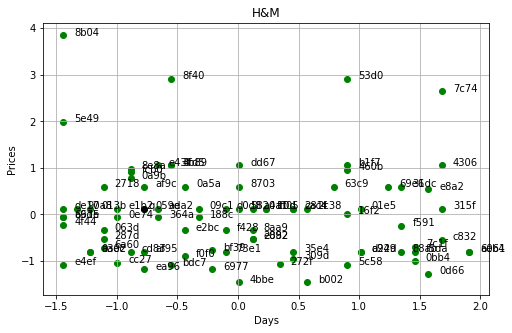

In [39]:
#check new scale
days = X_train_scaled[:,0] # x
prices = X_train_scaled[:,1] # y

q_days = q_scaled[0,0]
q_price = q_scaled[0,1]

plt.figure(figsize=(8,5))
plt.scatter(days, prices, color='green')

plt.scatter(q_days, q_price,color='black')
plt.annotate('q',(q_days+0.03, q_price))

plt.title("H&M")
plt.xlabel("Days")
plt.ylabel("Prices")
plt.grid()
#plt.legend(handles=[red_patch, blue_patch],loc=4)
for i, txt in enumerate(names):
    plt.annotate(txt[0:4], (days[i]+0.09, prices[i]))

# Train a KNN Model on Sample

In [40]:
knn_model = NearestNeighbors(n_neighbors=12, radius=0.4)
knn_model.fit(X_train_scaled)

NearestNeighbors(n_neighbors=12, radius=0.4)

# Predict with KNN Model

In [41]:
#get neighbours' names where k=12
result = knn_model.kneighbors(q_scaled, 12)[1][0]#requre 12 nearest neighbors to our query

In [42]:
#result #array([43, 74, 50, 26, 57, 56, 47, 37, 77, 32, 82, 16], dtype=int64)
for n in result:
    print(n)

83
35
82
52
77
68
78
10
74
51
21
72


In [43]:
# result contains the 'index' of the nearest neighbours
for n in result:
    cus = y_train[n]
    trans = sample_df.query('customer_id.str.contains("'+ cus + '")')
    p = trans.article_id.values
    p = str(p[0])
    item = articles_df.query('article_id.str.contains("'+ p + '")')
    print("PRODUCT: " + str(p))
    print(item.iloc[0][4])
    print(" ")

PRODUCT: 904736002
Wide belt with a round metal buckle.
 
PRODUCT: 754238007
Sports bra in fast-drying functional fabric. Lined front with removable inserts, a racer back and a wide elasticated hem. Extra firm support.
 
PRODUCT: 843380004
Small shoulder bag in woven fabric with imitation leather details. Zip at the top and a detachable, adjustable fabric shoulder strap. One zipped outer compartment and one inner compartment. Lined. Depth 6.5 cm, height 12.5 cm, width 19 cm.
 
PRODUCT: 909925004
Top in soft, organic cotton sweatshirt fabric with a round neckline, dropped shoulders and long sleeves. Ribbing around the neckline, cuffs and hem.
 
PRODUCT: 863583002
Round-necked jumper in a soft, rib-knit cotton blend. Relaxed fit with dropped shoulders, long, wide sleeves and a straight hem.
 
PRODUCT: 909924002
Trousers in soft, organic cotton sweatshirt fabric with elastication and a concealed drawstring at the waist, discreet pockets in the side seams and elasticated hems. Soft brushed

# Evaluate Model on Sample

In [44]:
names = y_test
y_pred = []

X_test_scaled = scaler.transform(X_test)

knn_model.fit(X_test_scaled)
pred_cus = knn_model.kneighbors(X_test_scaled, len(y_test))[1][0]
#print(y_test[pred_cus])
y_pred = y_test[pred_cus]

In [45]:
print(y_test)

['fc10bbb6285657a5635181830909a30ae8c61f0b7e45c87f08f183e18fcae49c'
 'd0921143dd2b4c3da2be14fa8d5bbe3a7e1988df74e5abf2d83e4564c25405e6'
 'b7ee81e0836144fdd92bde3dc2f7cf5060f8de5eb761f3f1b72b0f3ad17bc175'
 'd0c86f56f29b6820df30d05c95c38917ec844f699e80509d1c920fbd1b2f97c7'
 '6de7905fa29c91c3bb92b71b2e5aa8b497d6d5b25b6f07288bbf2457f115c061'
 'bf86e70fa996cb886d413400b4b192bac8709f7131d01ce97d5916018e621d0a'
 'd3bdf5f94b4f6119a895d6fbf982c4fe3a988e0097d4d8c5d83d15065e72826c'
 '9e18c1d733123393843dbd4b4522bec0fa18562938c886ae98cd784fd1a241cb'
 'f5267bf9f9323261e870852c99e74495a36944d36e2ef028a2570d9d011490d8'
 'a0d31ef0a9a1864c4a39571b7e7f73e593e6e3e7be88c211c6fcfa7b5b4c373d'
 'f0deb9f0724a31c6ce08e282b1061b3a2948e2aefd8751e98021da7b45052b5c'
 'd2f1cc944bc16695a914a295ac03a6d6cc99180219beb2b422793792456ef617'
 'b12201d9b10dbd17af5678dd4fc5c74089f3f9c251f67d9c43a9a72e6f0bda3b'
 'e43c29bfc284871206aa12cabf032e846dde451fc13228508bedc5cdd4a93150'
 '5dc52cf061cd132ee0b5e0e67e2ef22b24c89f2ccd6c47

In [46]:
print(y_pred)

['fc10bbb6285657a5635181830909a30ae8c61f0b7e45c87f08f183e18fcae49c'
 'e43c29bfc284871206aa12cabf032e846dde451fc13228508bedc5cdd4a93150'
 'd0921143dd2b4c3da2be14fa8d5bbe3a7e1988df74e5abf2d83e4564c25405e6'
 'd3bdf5f94b4f6119a895d6fbf982c4fe3a988e0097d4d8c5d83d15065e72826c'
 'd2f1cc944bc16695a914a295ac03a6d6cc99180219beb2b422793792456ef617'
 '5dc52cf061cd132ee0b5e0e67e2ef22b24c89f2ccd6c47501ad3e060bdf2abd2'
 '9e18c1d733123393843dbd4b4522bec0fa18562938c886ae98cd784fd1a241cb'
 'a0d31ef0a9a1864c4a39571b7e7f73e593e6e3e7be88c211c6fcfa7b5b4c373d'
 'd0c86f56f29b6820df30d05c95c38917ec844f699e80509d1c920fbd1b2f97c7'
 '4061d21530a753bb13242f44154b75b83c653dba9d95a520f6e1d275947d2316'
 'f5267bf9f9323261e870852c99e74495a36944d36e2ef028a2570d9d011490d8'
 'f0deb9f0724a31c6ce08e282b1061b3a2948e2aefd8751e98021da7b45052b5c'
 'b7ee81e0836144fdd92bde3dc2f7cf5060f8de5eb761f3f1b72b0f3ad17bc175'
 'bf86e70fa996cb886d413400b4b192bac8709f7131d01ce97d5916018e621d0a'
 '6de7905fa29c91c3bb92b71b2e5aa8b497d6d5b25b6f07

In [47]:
precision_score(y_test, y_pred, average='micro')

0.0625

In [48]:
accuracy_score(y_test, y_pred)

0.0625

# Generate Predictions File

### Prepare Customer Dataset

H&M are expecting about 1,371,980 prediction rows, we will only have 1,362,281 because 9,699 customers have not purchased anything yet.

Originally we were going to generate a list of missing customers, determine their demographics and match to those who have made transactions then use their values to fill the missing. This however was computationally expensive.

In [49]:
customers_df['customer_id'].size

1371980

In [50]:
cus_pred_df = transactions_train_df.groupby(transactions_train_df.customer_id)[['day','price']].median()

In [51]:
cus_pred_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1362281 entries, 00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657 to ffffd9ac14e89946416d80e791d064701994755c3ab686a1eaf3458c36f52241
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   day     1362281 non-null  float64
 1   price   1362281 non-null  float64
dtypes: float64(2)
memory usage: 31.2+ MB


In [52]:
cus_pred_df['day'].size #we set articles column to index

1362281

In [53]:
cus_pred_df['customer_id'] = cus_pred_df.index

In [54]:
cus_pred_df = cus_pred_df.reset_index(drop=True)

In [55]:
cus_pred_df = cus_pred_df[['customer_id', 'day', 'price']]

In [56]:
cus_pred_df.head()

,customer_id,day,price
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,25.0,0.030492
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,21.0,0.025407
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,18.0,0.033881
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,9.0,0.030492
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,9.0,0.033881


In [57]:
non_transaction_customers_df = customers_df[~customers_df['customer_id'].isin(cus_pred_df['customer_id'])]

In [58]:
non_transaction_customers_df['day'] = 0

C:\Users\newlo\AppData\Local\Temp\ipykernel_5528\3592874415.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_transaction_customers_df['day'] = 0


In [59]:
non_transaction_customers_df['price'] = 0.0

C:\Users\newlo\AppData\Local\Temp\ipykernel_5528\2901366215.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_transaction_customers_df['price'] = 0.0


In [60]:
non_transaction_customers_df = non_transaction_customers_df.drop(['FN', 'Active', 'club_member_status', 'fashion_news_frequency', 'age', 'postal_code'], axis=1)

#we now reorganise the dataset to treat articles as the predictor
non_transaction_customers_df = non_transaction_customers_df[['customer_id', 'day', 'price']]

In [61]:
non_transaction_customers_df['customer_id'].size

9699

In [62]:
non_transaction_customers_df = non_transaction_customers_df.reset_index(drop=True)

In [63]:
non_transaction_customers_df.head()

,customer_id,day,price
0,00058ecf091cea1bba9d800cabac6ed1ae284202cdab68...,0,0.0
1,000df4d2084d142416b8165bdd249bab8fea2393447aed...,0,0.0
2,00193ff7f374dbcfecfa7fead0488e454be4918bec1ebd...,0,0.0
3,001f00e8c1eba437ff0dbad26a9a3d49e47cbf05fff02a...,0,0.0
4,002648d8f3b288531b24860f4a68a31d029ec5a0495c04...,0,0.0


In [64]:
cus_pred_df = cus_pred_df.append(non_transaction_customers_df)

C:\Users\newlo\AppData\Local\Temp\ipykernel_5528\935700407.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cus_pred_df = cus_pred_df.append(non_transaction_customers_df)


In [124]:
del(customers_df) #delete dataframe
gc.collect() #collect garbage

14152

In [65]:
cus_pred_df.tail()

,customer_id,day,price
9694,ffe5801cb2a5b51d4d068322d7f8082e995f427a6f22a6...,0.0,0.0
9695,ffeb3ca867aba57a312fe9d28d67dd46ef2240fe92a94c...,0.0,0.0
9696,fff456fa60aac9174456c2f36ede5e0f25429a16c88a34...,0.0,0.0
9697,fffa8d3cea26d4f5186472b923629b35fa28051f258030...,0.0,0.0
9698,ffff01710b4f0d558ff62d7dc00f0641065b37e840bb43...,0.0,0.0


In [66]:
#we set articles column to index
cus_pred_df.set_index('customer_id')

,day,price
customer_id,,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,25.0,0.030492
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,21.0,0.025407
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,18.0,0.033881
00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e,9.0,0.030492
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,9.0,0.033881
...,...,...
ffe5801cb2a5b51d4d068322d7f8082e995f427a6f22a6f471e773a29a27a3d0,0.0,0.000000
ffeb3ca867aba57a312fe9d28d67dd46ef2240fe92a94c434a0debd1902c386a,0.0,0.000000
fff456fa60aac9174456c2f36ede5e0f25429a16c88a346dfb99333eb604cd6f,0.0,0.000000


### Check Missing Values

In [67]:
missing = cus_pred_df.isin([0]).sum(axis=1)
print(cus_pred_df.shape)
print(missing)

(1371980, 3)
0       0
1       0
2       0
3       0
4       0
       ..
9694    2
9695    2
9696    2
9697    2
9698    2
Length: 1371980, dtype: int64


### Fix Missing / Zero Values

In [68]:
cus_pred_df['day'] = cus_pred_df['day'].replace(0, cus_pred_df['day'].median())

In [69]:
cus_pred_df['price'] = cus_pred_df['price'].replace(0, cus_pred_df['price'].median())

In [70]:
missing = cus_pred_df.isin([0]).sum(axis=1)
print(cus_pred_df.shape)
print(missing)

(1371980, 3)
0       0
1       0
2       0
3       0
4       0
       ..
9694    0
9695    0
9696    0
9697    0
9698    0
Length: 1371980, dtype: int64


In [71]:
cus_pred_df.tail()

,customer_id,day,price
9694,ffe5801cb2a5b51d4d068322d7f8082e995f427a6f22a6...,17.0,0.025407
9695,ffeb3ca867aba57a312fe9d28d67dd46ef2240fe92a94c...,17.0,0.025407
9696,fff456fa60aac9174456c2f36ede5e0f25429a16c88a34...,17.0,0.025407
9697,fffa8d3cea26d4f5186472b923629b35fa28051f258030...,17.0,0.025407
9698,ffff01710b4f0d558ff62d7dc00f0641065b37e840bb43...,17.0,0.025407


In [79]:
s = cus_pred_df.values

### File generation function

In [119]:
#H&M Collaborative KNN Model Based Recommendation System
def generate_prediction_file(r_model, cus_df, write_file):  
    #get values
    X = cus_df.values

    y = X[:,0]
    names = y
    
    X = X[:,1:] # day and price

    
  
    #write_file = "ros_predictions.csv"
    with open(write_file, "wt", encoding="utf-8") as output:
        #add headers first
        output.write("customer_id, prediction" + '\n')
        
        #now we loop through each row and write predictions to csv file
        for index, cus in cus_df.iterrows():
            #select day and price and convert them to np array
            q_cus = np.array([cus['day'],cus['price']], dtype=float) #cus[3:5]
            
            #normalise data
            q_cus_scaled = scaler.transform([q_cus])

            #get neighbours' names where k=12
            result = r_model.kneighbors(q_cus_scaled, 12)[1][0]
            
            #create prediction csv file
            r = []
            r.append(cus.customer_id + ",")
            for n in result:
                c = names[n] 
                trans = transactions_train_df.query('customer_id.str.contains("'+ c + '")')
                p = trans.article_id.values
                r.append("0" + str(p[0]))
                prediction =  ' '.join(r)
            #write predictions to csv file
            output.write(prediction + '\n')
            clear_output(wait=True)
            display('Processed Row: ' + str(index))

### Generate the file

In [120]:
#we now generate our intial predictions list and save it as a csv file
generate_prediction_file(knn_model, cus_pred_df, "data/ros_predictions5.csv")

KeyboardInterrupt: 

### Check submission file

In [ ]:
#inspect our prediction data
predictions_df = pd.read_csv("data/ros_predictions5.csv")

In [ ]:
predictions_df.head()

In [ ]:
predictions_df['customer_id'].size